In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Style transfer

In [ ]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
import time

torch.backends.cudnn.benchmark=True

PATH = Path('data/imagenet')
PATH_TRN = PATH/'train'

m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

face = 'input.jpg'
img_fn = PATH_TRN/face
img = open_image(f"{img_fn}")
plt.imshow(img);

sz=512

trn_tfms,val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)
img_tfm.shape

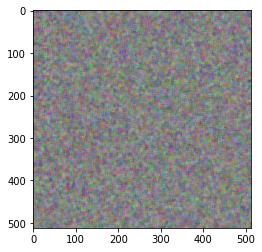

In [20]:
opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)

opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])

plt.imshow(opt_img);

In [21]:
#set train image = input image

#opt_img = open_image(f"{img_fn}")
opt_img = val_tfms(opt_img)/2
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 512, 512])

In [22]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

def actn_loss(x): return F.mse_loss(m_vgg(x), targ_v)*1e3

def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

## forward hook

In [23]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

def actn_loss2(x):
    m_vgg(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*1e3

block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

## Style match

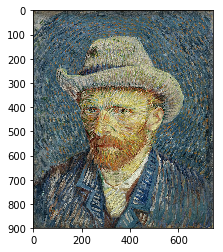

In [24]:
style_fn = PATH/'style'/'van-gogh.jpg'

style_img = open_image(f"{style_fn}")
style_img.shape, img.shape

plt.imshow(style_img);

((512, 512, 3), (512, 512, 3))

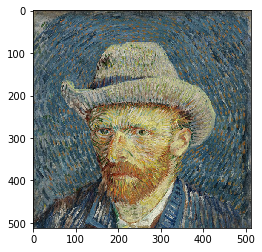

In [25]:
def scale_match(src, targ):
    h,w,_ = img.shape
    sh,sw,_ = style_img.shape
    rat = max(h/sh,w/sw); rat
    res = cv2.resize(style_img, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

style = scale_match(img, style_img)

plt.imshow(style)
style.shape, img.shape

In [ ]:
opt_img_v, optimizer = get_opt()

sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

style_tfm = val_tfms(style_img)

In [ ]:
m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

In [11]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

def style_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    return sum(losses)

## Style transfer

In [12]:
opt_img_v, optimizer = get_opt()

In [12]:
def comb_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    cnt_loss   = F.mse_loss(outs[0], targ_vs[0])*1e4 + F.mse_loss(outs[2], targ_vs[2])*1e6
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [ ]:
n_iter=0
while n_iter <= max_iter/2: optimizer.step(partial(step,comb_loss))

In [ ]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(9,9))
plt.imshow(x, interpolation='lanczos')
plt.axis('off');

timestr = time.strftime("%Y%m%d-%H%M%S")
out_fn = PATH/'predict'/f"{timestr} {face}"
plt.savefig(out_fn)

In [214]:
for sf in sfs: sf.close()